# Setup and Install

In [1]:
# Make things work on google colab
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/winter24-project/Trustworthy-GNN-for-Financial-Time-Series')

Mounted at /content/drive/


In [2]:
# !pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

In [3]:
!pip install networkx --upgrade
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00


# Dataset

In [4]:
from data_provider.datasets import SP500Dataset, train_test_split, TSDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
stock_dataset = SP500Dataset()
data_numpy = stock_dataset.get_data_numpy(log_return=False)
train_data, test_data = train_test_split(data_numpy, train_size=0.8)

window_size = 22 * 3
horizon = 22
stride = 7
nodes_num = data_numpy.shape[1]
train_dataset = TSDataset(train_data, window_size, horizon, stride)
test_dataset = TSDataset(test_data, window_size, horizon, stride)
print('train samples: ', len(train_dataset), '\ntest samples: ', len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

train samples:  400 
test samples:  91


In [5]:
stock_dataset.get_names()[0]

'A'

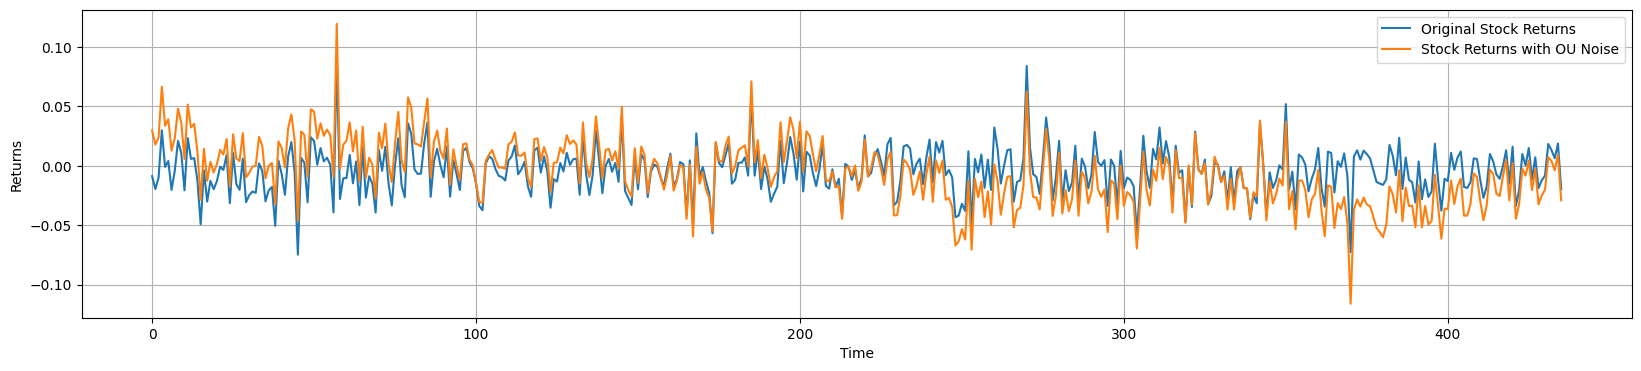

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp, log

stock_return_numpy = stock_dataset.get_data_numpy(log_return=True)

def add_ou_noise(stock_return_numpy, theta, mu, sigma, dt):
    num_stocks, length = stock_return_numpy.shape
    noise = np.random.normal(loc=0.0, scale=1.0, size=(num_stocks, length)) * np.sqrt(dt)
    ou_noise = np.zeros((num_stocks, length))
    ou_noise[:, 0] = noise[:, 0]

    for i in range(1, length):
        ou_noise[:, i] = ou_noise[:, i - 1] * exp(-theta * dt) + mu * (1 - exp(-theta * dt)) + sigma * noise[:, i]

    ou_noise_scaled = ou_noise * np.std(stock_return_numpy) / np.std(ou_noise)

    return stock_return_numpy + ou_noise_scaled

theta = 5.0
mu = np.mean(stock_return_numpy, axis=1)
sigma = 0.1
dt = 1 / stock_return_numpy.shape[1]

stock_return_with_ou_noise = add_ou_noise(stock_return_numpy, theta, mu, sigma, dt)

# Plot original stock returns and with OU noise
plt.figure(figsize=(20, 4))
plt.plot(stock_return_numpy[400], label='Original Stock Returns')
plt.plot(stock_return_with_ou_noise[400], label='Stock Returns with OU Noise')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

# Construct Graph

Normalizing the data's variance...
436 nodes and 3604 time samples
Fitting the model...


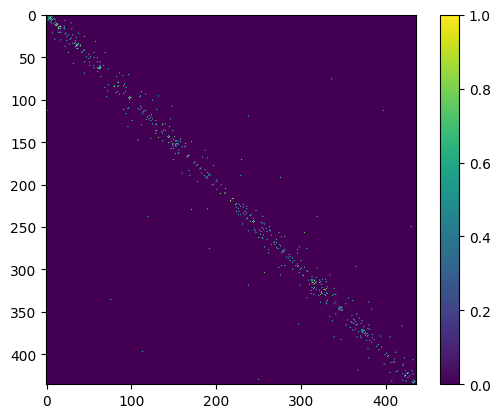

In [7]:
from util.construct_graph import GraphConstructor, draw_heat_map
gc = GraphConstructor(add_ou_noise(stock_return_numpy, theta, mu, sigma, dt), alpha=0.2, max_iter=200)
# gc = GraphConstructor(train_data, alpha=0.2, max_iter=200)
tho_adj = 0.25
adj = gc.get_adjacency_matrix(tho_adj)
draw_heat_map(adj)

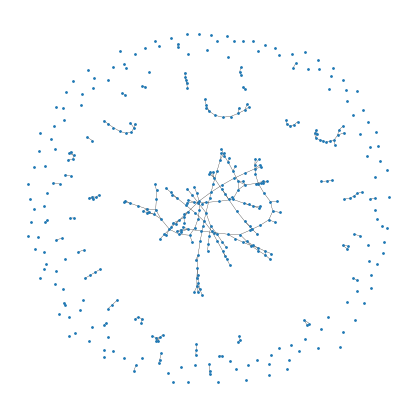

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

adjacency_matrix = gc.get_adjacency_matrix(tho_adj)
# G = nx.from_numpy_matrix(adjacency_matrix)
G = nx.from_numpy_array(adjacency_matrix)
if len(gc.names) == gc.n:
    G = nx.relabel_nodes(G, dict(enumerate(gc.names)))
# pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
pos = nx.spring_layout(G)
# pos = nx.kamada_kawai_layout(G)
# plt.figure(3, figsize=(30, 30))
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=False,pos=pos, node_size=1, width=0.2)
plt.show()

# Train Model

epoch:  0 loss:  25811.70395690918 test loss:  143870.88787774724


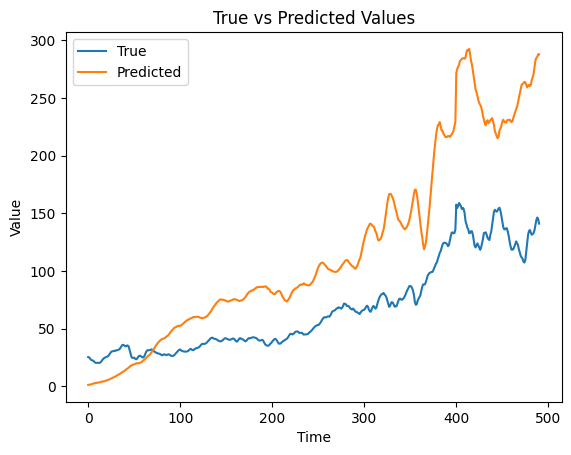

epoch:  1 loss:  25698.300046997072 test loss:  143829.51742788462


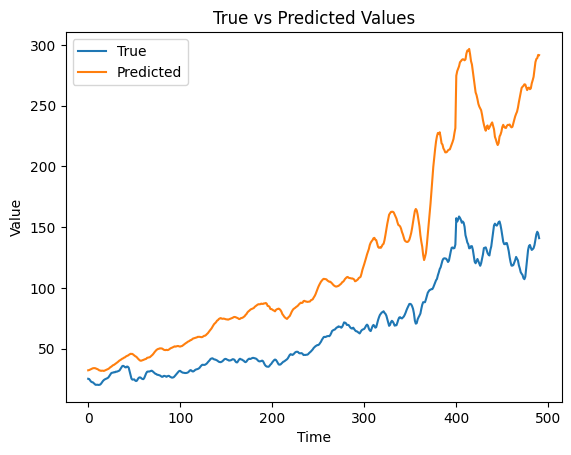

epoch:  2 loss:  25673.798575439454 test loss:  143770.79781936813


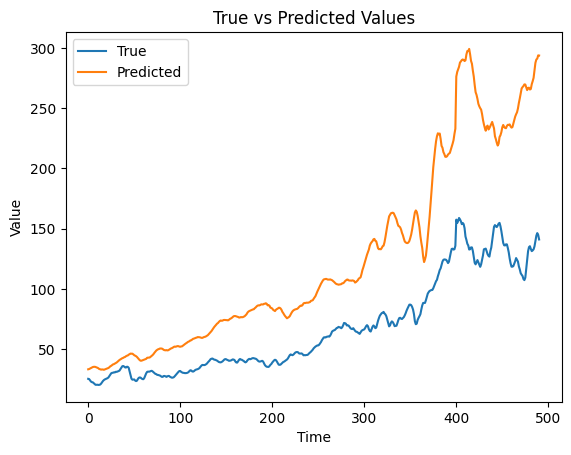

epoch:  3 loss:  25642.935595092775 test loss:  143683.92908653847


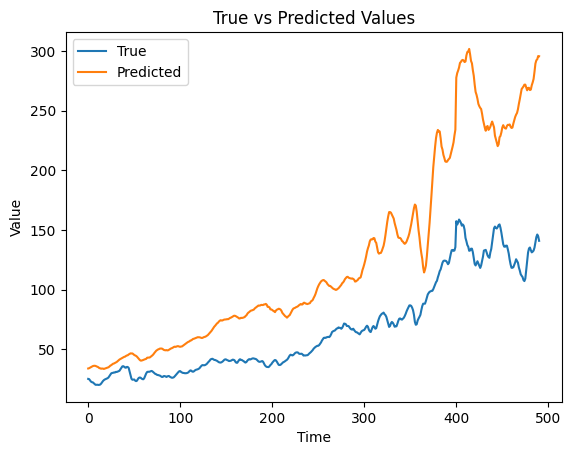

epoch:  4 loss:  25603.08789550781 test loss:  143629.18818681317


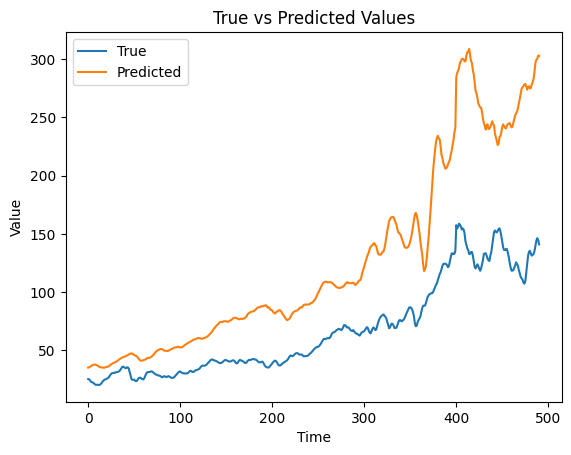

epoch:  5 loss:  25527.34453430176 test loss:  143565.61092032967


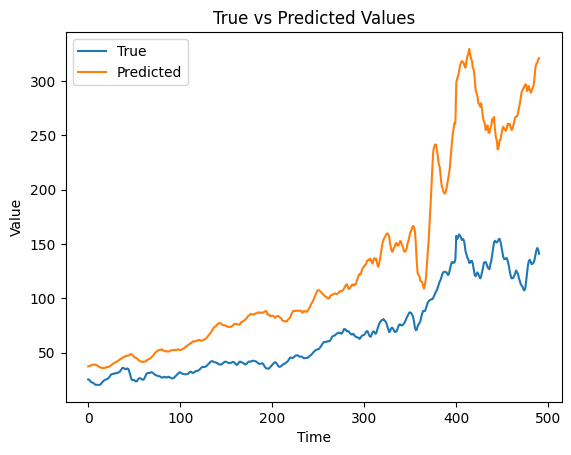

epoch:  6 loss:  25277.628334960937 test loss:  141550.7636504121


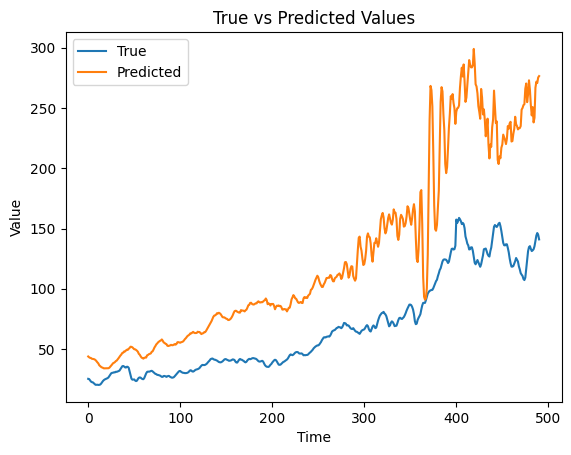

epoch:  7 loss:  24873.97672241211 test loss:  140063.86109203298


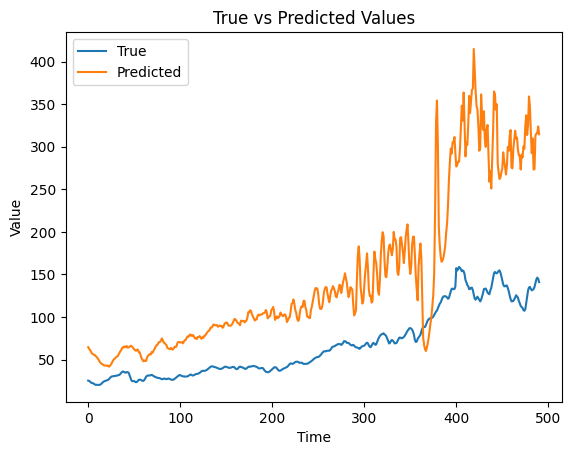

epoch:  8 loss:  24754.76132598877 test loss:  140897.71978021978


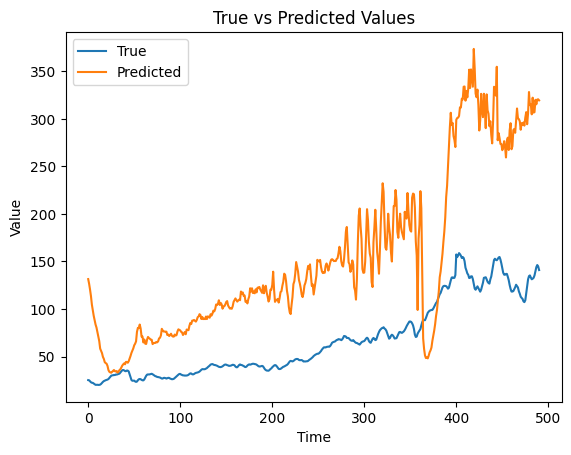

epoch:  9 loss:  24670.644838256834 test loss:  139875.58267513735


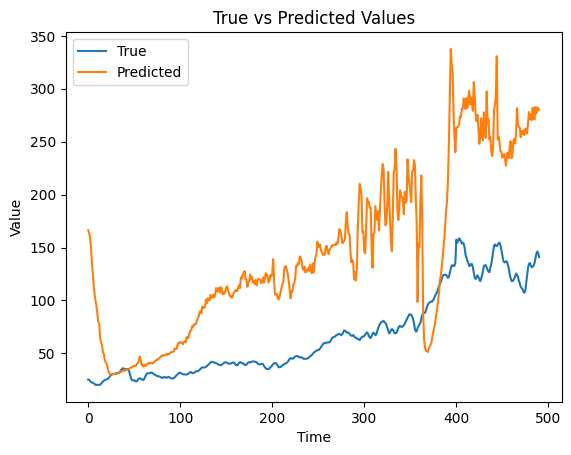

epoch:  10 loss:  24690.843755493162 test loss:  142323.35928914836


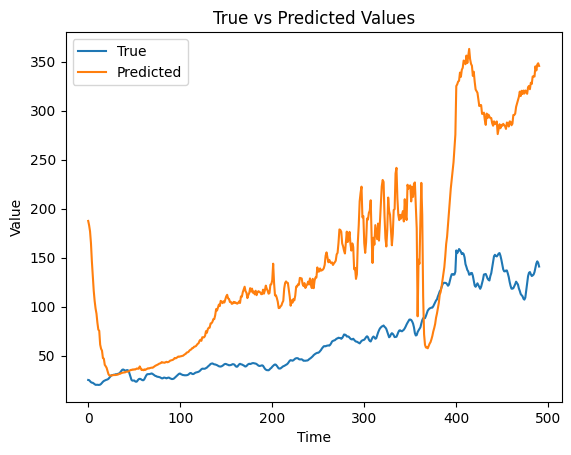

epoch:  11 loss:  24587.202575073243 test loss:  139186.9426510989


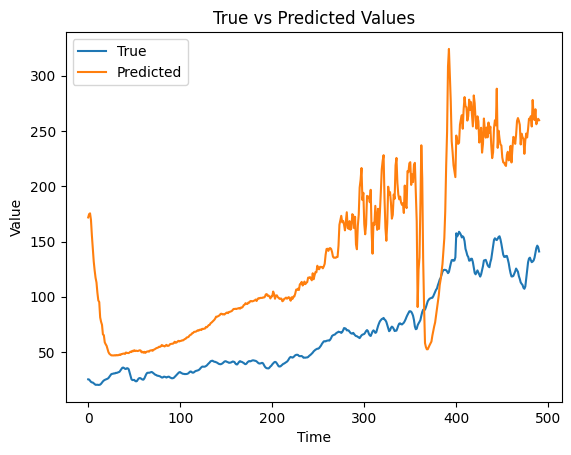

epoch:  12 loss:  24475.218860473633 test loss:  138310.16328983515


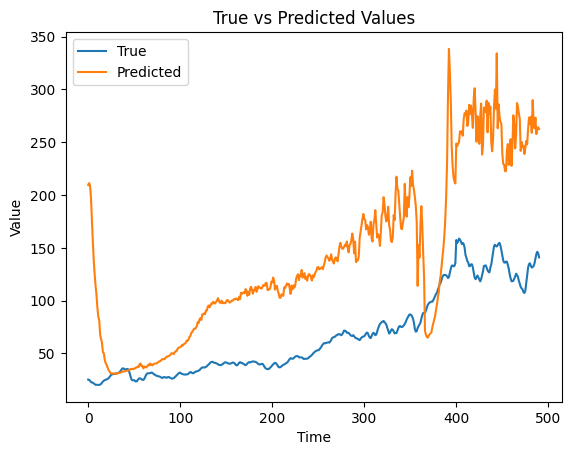

epoch:  13 loss:  24335.085041503906 test loss:  136420.64972527474


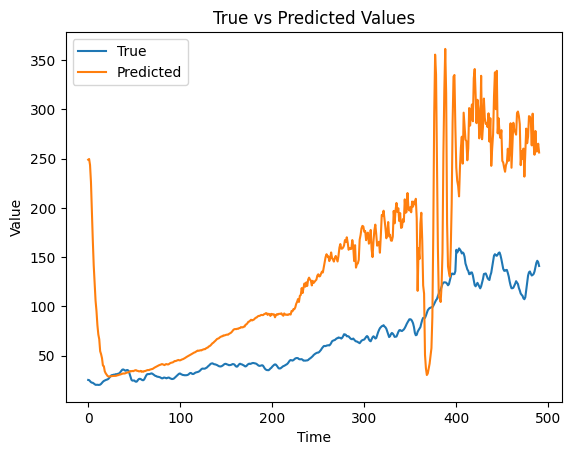

epoch:  14 loss:  24082.009363098143 test loss:  136047.14354395604


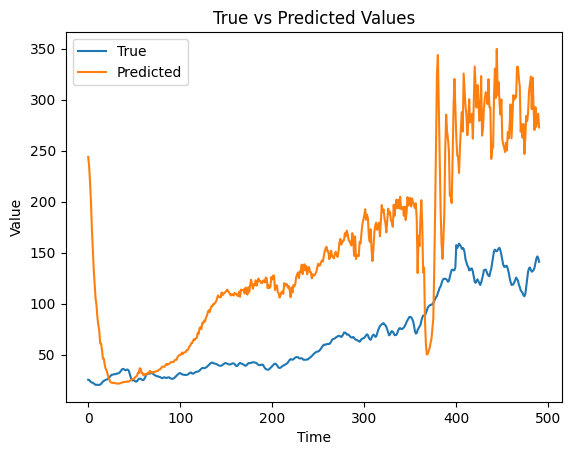

In [10]:
from modelling.graph_model import TempGNN
from tqdm.notebook import tqdm
from torch_geometric.nn import GCNConv, GINConv
import torch.nn as nn


# seed
torch.manual_seed(2024)

devce = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = TempGNN(window_size).to(devce)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
edge_index = torch.nonzero(torch.tensor(adj)).t().contiguous().to(devce)


def loss_fn(output, target, epsilon=1e-8):
    relative_errors = torch.abs((output - target) / (target+epsilon))
    return torch.mean(relative_errors)

criterion = nn.MSELoss()

# def loss_fn(y_pred, y_true):
#     return F.mse_loss(y_pred, y_true)

model.train()
for epoch in range(15):
    y_history = {'true':[], 'pred':[]}
    total_loss = 0
    # for x, y in tqdm(train_loader):
    for i, (x, y)in enumerate(train_loader):
        x, y = x.to(devce), y.to(devce)

        optimizer.zero_grad()
        # print(x.shape, y.shape)
        y_mean = torch.mean(y, dim=2)
        # y_logvar = torch.log(torch.var(y, dim=1))
        # make edge_index batched
        # edge_index_batched = edge_index.repeat(x.shape[0], 1)
        y_pred = model(x, edge_index)
        loss = criterion(y_pred, y_mean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        y_history['true'].append(y_mean[0][0].item())
        y_history['pred'].append(y_pred[0][0].item())

    total_loss_test = 0
    # for x, y in tqdm(test_loader):
    for x, y in test_loader:
        x, y = x.to(devce), y.to(devce)
        y_mean = torch.mean(y, dim=2)
        y_pred = model(x, edge_index)
        loss = criterion(y_pred, y_mean)
        total_loss_test += loss.item()
        y_history['true'].append(y_mean[0][0].item())
        y_history['pred'].append(y_pred[0][0].item())

    print('epoch: ', epoch, 'loss: ', total_loss / len(train_loader), 'test loss: ', total_loss_test / len(test_loader))
    import matplotlib.pyplot as plt
    # Plot the true and predicted values
    # plt.figure(figsize=(10, 6))
    plt.plot(y_history['true'], label='True')
    plt.plot(y_history['pred'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()





# Baseline (LSTM) Performance

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, hidden1 = self.lstm1(x)
        x, hidden2 = self.lstm2(x)
        output = self.fc(x)
        return output


epoch:  0 loss:  24658.097192993166 test loss:  139478.57855425825


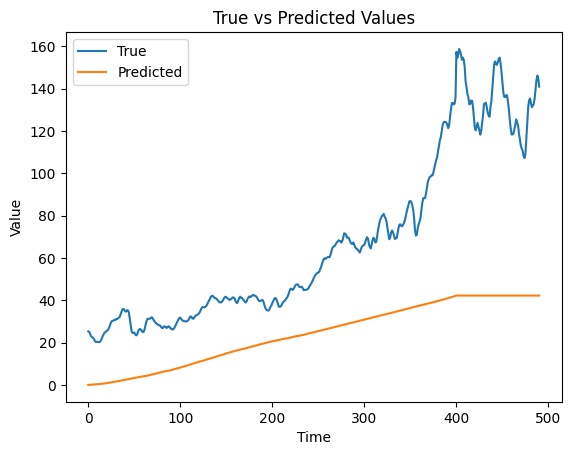

epoch:  1 loss:  22359.484205627443 test loss:  134283.52197802198


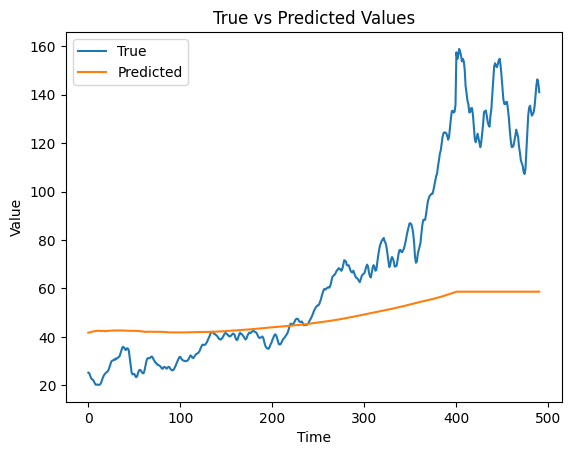

epoch:  2 loss:  22158.453458862306 test loss:  132808.57374656593


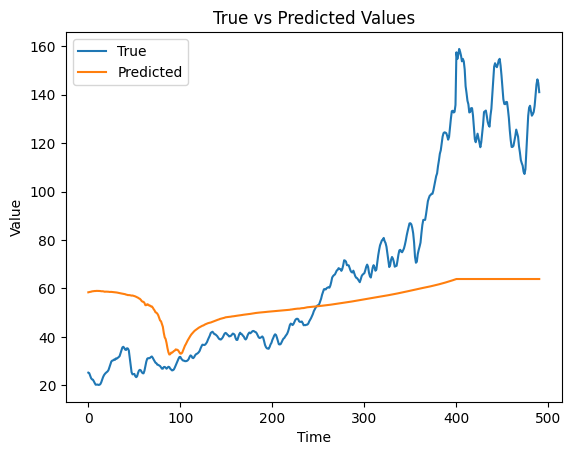

epoch:  3 loss:  22012.76088684082 test loss:  131481.0818166209


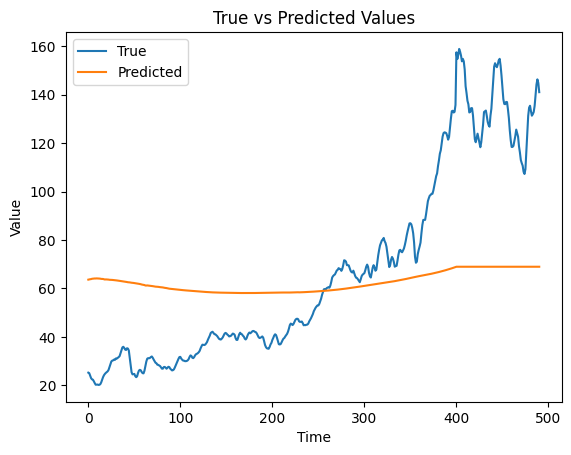

epoch:  4 loss:  21914.23879760742 test loss:  130347.07881181319


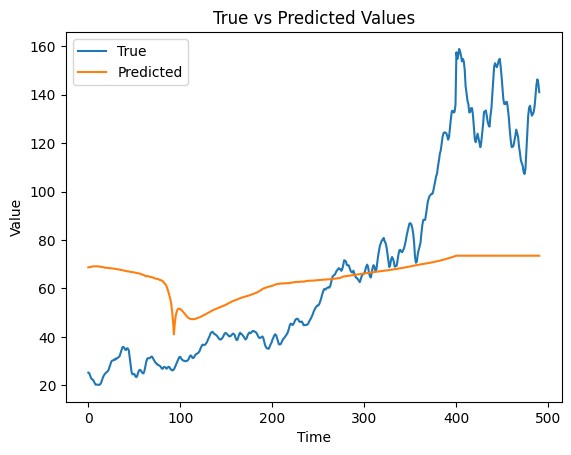

epoch:  5 loss:  22016.23418029785 test loss:  129420.60267857143


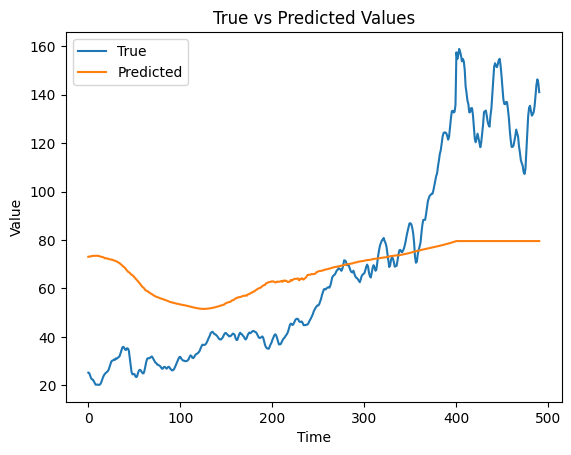

epoch:  6 loss:  21553.919351806642 test loss:  128428.80013736263


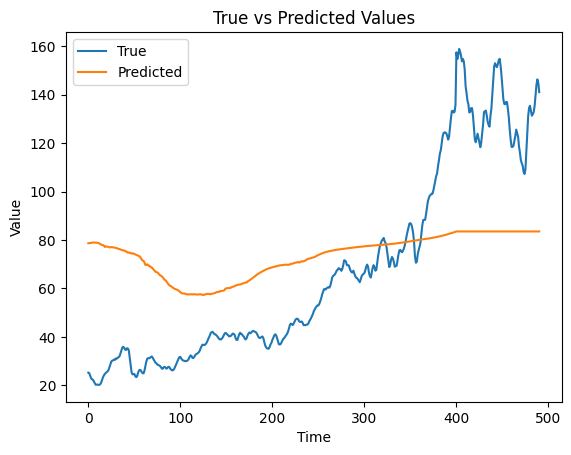

epoch:  7 loss:  21232.79459716797 test loss:  127179.15273008242


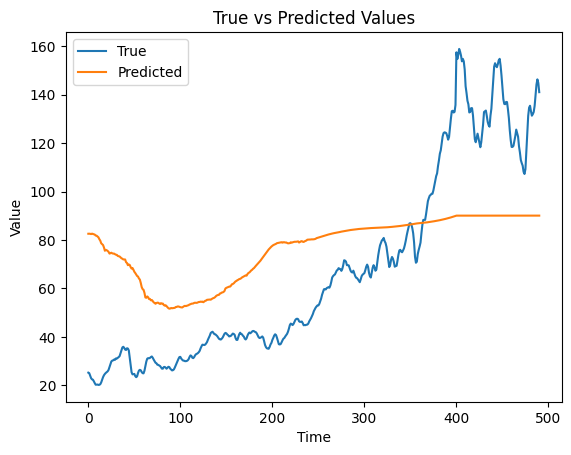

epoch:  8 loss:  21098.852576293946 test loss:  126390.72956730769


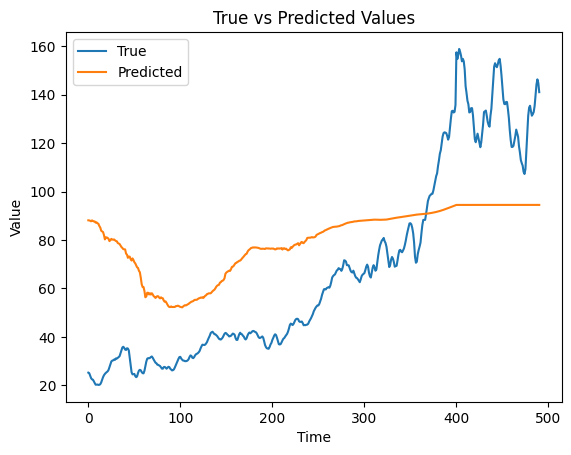

epoch:  9 loss:  21036.21862121582 test loss:  125793.70698832418


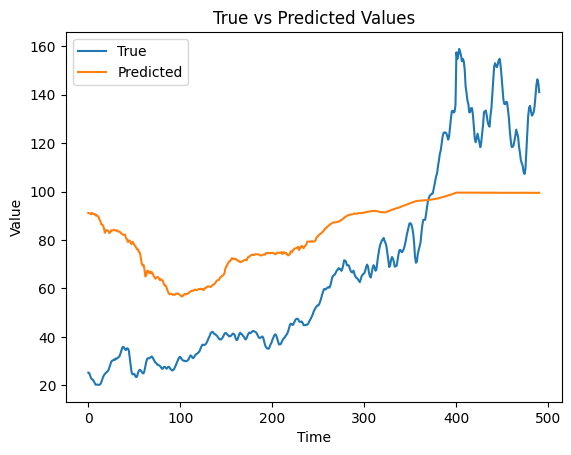

epoch:  10 loss:  21021.93854949951 test loss:  125390.1978021978


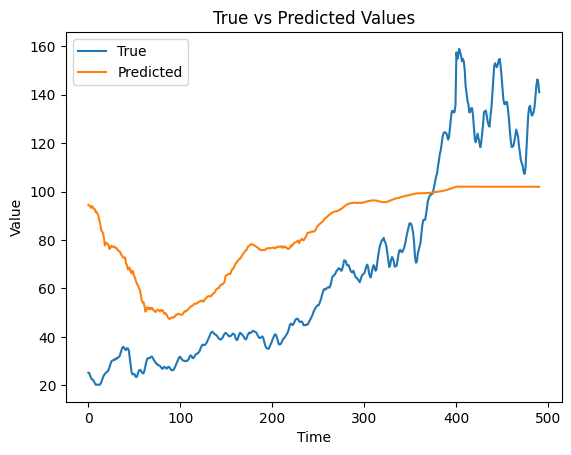

epoch:  11 loss:  20989.978413391113 test loss:  124946.83009958791


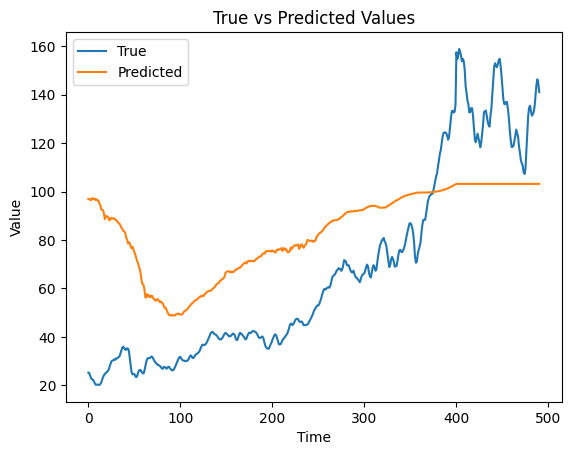

epoch:  12 loss:  20970.122407836912 test loss:  124729.41114354396


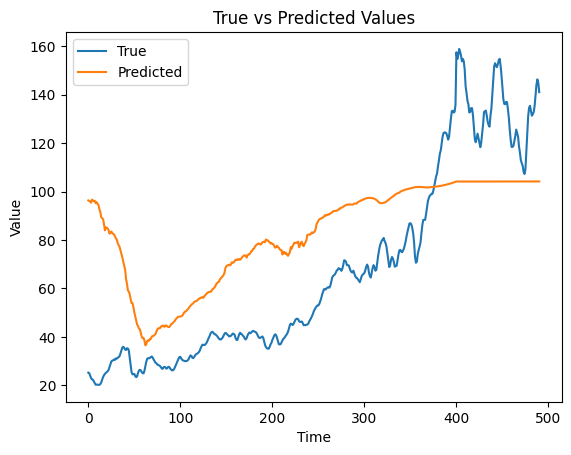

epoch:  13 loss:  20961.73355163574 test loss:  124512.08121565935


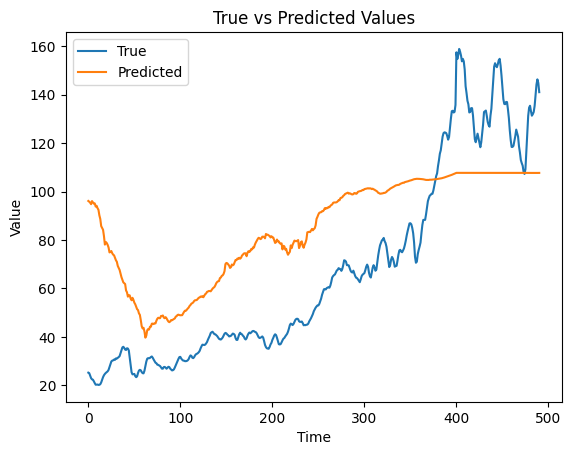

epoch:  14 loss:  20967.053545532228 test loss:  124568.37422733517


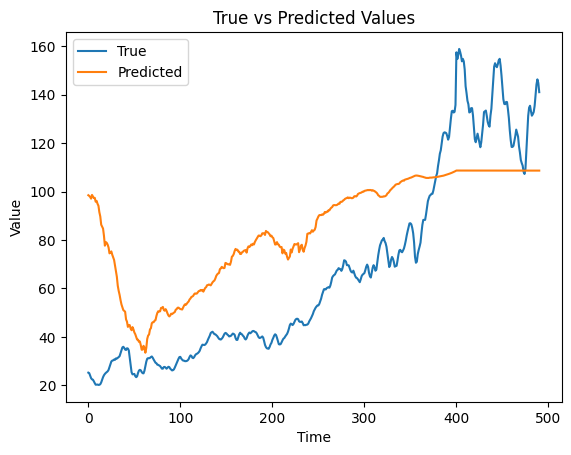

In [ ]:
torch.manual_seed(2024)

devce = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_baseline = LSTMModel(input_size=1, hidden_size=100, output_size=1).to(devce)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=0.001)

model_baseline.train()
for epoch in range(15):
    y_history = {'true':[], 'pred':[]}
    total_loss = 0
    for i, (x, y)in enumerate(train_loader):
        x, y = x.to(devce), y.to(devce)
        bsz, num_nodes, seq_len = x.shape
        # _x = x[:,0,:].unsqueeze(-1)
        # _y = y[:,0,:]
        _x = x.reshape(-1, seq_len, 1)
        _y = y.reshape(-1, horizon)
        optimizer.zero_grad()
        y_mean = torch.mean(_y, dim=1)
        y_pred = model_baseline(_x)[-1]
        loss = criterion(y_pred, y_mean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        y_history['true'].append(y_mean[0].item())
        y_history['pred'].append(y_pred[0].item())

    total_loss_test = 0
    # for x, y in tqdm(test_loader):
    for x, y in test_loader:
        x, y = x.to(devce), y.to(devce)
        bsz, num_nodes, seq_len = x.shape
        # x = x[:,0,:].unsqueeze(-1)
        # y = y[:,0,:]
        _x = x.reshape(-1, seq_len, 1)
        _y = y.reshape(-1, horizon)
        y_mean = torch.mean(_y, dim=1)
        y_pred = model_baseline(_x)[-1]
        loss = criterion(y_pred, y_mean)
        total_loss_test += loss.item()
        y_history['true'].append(y_mean[0].item())
        y_history['pred'].append(y_pred[0].item())

    print('epoch: ', epoch, 'loss: ', total_loss / len(train_loader), 'test loss: ', total_loss_test / len(test_loader))
    import matplotlib.pyplot as plt
    # Plot the true and predicted values
    # plt.figure(figsize=(10, 6))
    plt.plot(y_history['true'], label='True')
    plt.plot(y_history['pred'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()

# Return Rate Distribution

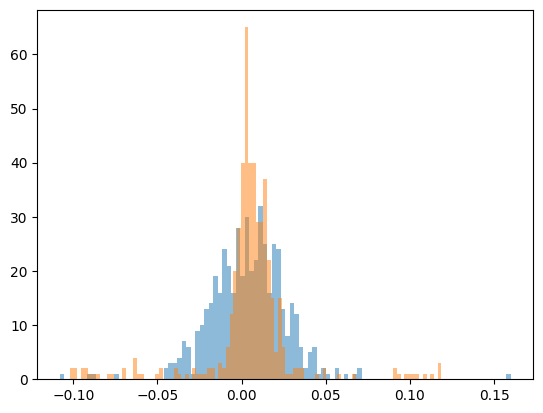

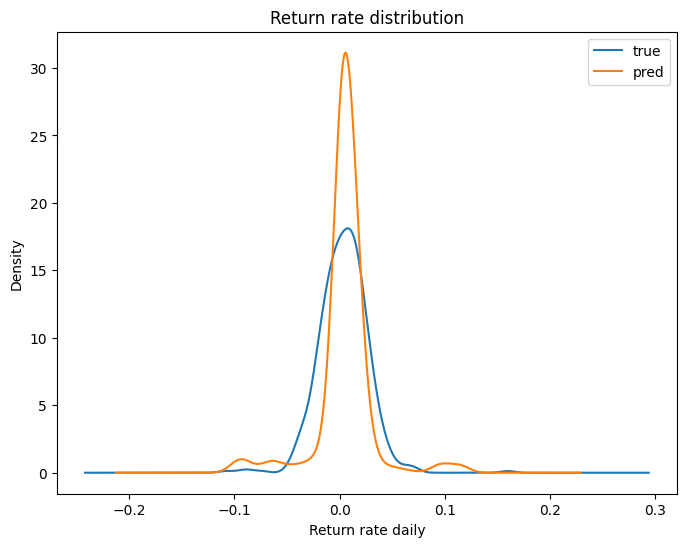

In [11]:
import pandas as pd
true_df = pd.DataFrame(y_history['true'])
pred_df = pd.DataFrame(y_history['pred'])
# pcnt change
true_df = true_df.pct_change()
pred_df = pred_df.pct_change()
true_df = true_df.dropna()
pred_df = pred_df.dropna()

# sliding window
window_size = 15
# true_df = true_df.rolling(window=window_size).mean()
pred_df = pred_df.rolling(window=window_size).mean()

# return distribution
plt.hist(true_df[0], bins=100, alpha=0.5, label='true')
plt.hist(pred_df[0], bins=100, alpha=0.5, label='pred')

# density plot in one figure
plt.figure(figsize=(8, 6))
true_df[0].plot.kde(label='true')
pred_df[0].plot.kde(label='pred')
plt.xlabel('Return rate daily')
plt.ylabel('Density')
plt.title('Return rate distribution')


plt.legend()
plt.show()


In [12]:
from torch_geometric.explain import Explainer,GNNExplainer
# from my_gnn_explainer import GNNExplainer

# x = np.random.randn(num_nodes,time_len)
# # generate edge index random
# edge_index = np.random.randint(0,num_nodes,(2,10))
# edge_index = torch.tensor(edge_index)
# x = torch.tensor(x).float()

# node_idx = 0
x, y = test_dataset[0]
x = x.to(devce)

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)
node_index = 123 #415

explanation = explainer(x, edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")
names = stock_dataset.get_names()
explanation.visualize_graph(backend='graphviz')

Generated explanations in ['edge_mask']


# Explanation

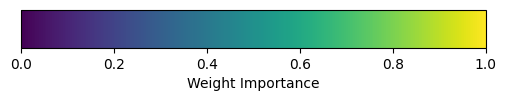

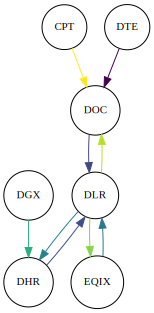

In [13]:
import util.my_visualize_graph
from util.my_visualize_graph import visualize_graph
# reimport visualize_graph
from importlib import reload
reload(util.my_visualize_graph)


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

cb = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                      norm=norm,
                                      orientation='horizontal')
cb.set_label('Weight Importance')
plt.show()

visualize_graph(edge_index=edge_index, edge_weight=explanation.edge_mask, backend='graphviz',
                node_labels=names)


In [14]:
import matplotlib.pyplot as plt

def plot_contributions(contributions, title=f'Contribution of Each Time Point'):
    contributions_sample = contributions.detach().numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(contributions_sample, label='Contribution', marker='o')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Contribution Value')
    plt.grid(True)
    plt.legend()
    plt.show()

In [25]:
def visualize_sequence_with_highlights(sequence, contribution, threshold=35, title=f'Important Time Points'):
    fig, ax = plt.subplots()
    plt.title(title)

    ax.plot(sequence, label='Original Sequence')

    for i, ig_value in enumerate(contribution):
        if abs(ig_value) > threshold:
            ax.plot(i, sequence[i], marker='o', markersize=4, color='red', label='Important Parts')

    plt.show()

In [26]:
def integrated_gradients(input, edge_index, baseline, model, steps=50, node_index=0):
    input = input.clone().detach().requires_grad_(True)
    baseline = baseline.clone().detach()

    interpolated = [baseline + (step / steps) * (input - baseline) for step in range(0, steps + 1)]

    grads = []
    for i, inp in enumerate(interpolated):
        if inp.grad is not None:
            inp.grad.zero_()
        inp.requires_grad_(True)
        with torch.autograd.set_grad_enabled(True):
            output = model(inp, edge_index)
            target_score = output[node_index] # target score at the node of interest
            grads.append(torch.autograd.grad(target_score, inp)[0])

    avg_grads = torch.stack(grads).mean(dim=0)
    integrated_grad = (input - baseline)[node_index] * avg_grads  # element-wise multiplication
    return integrated_grad

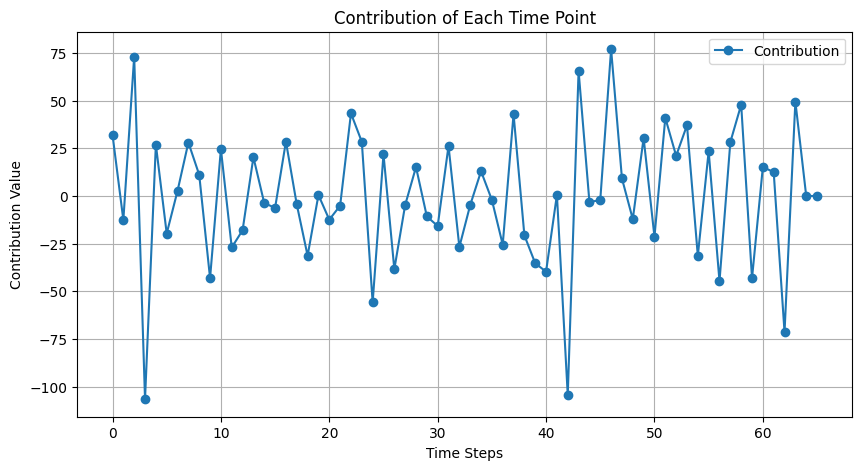

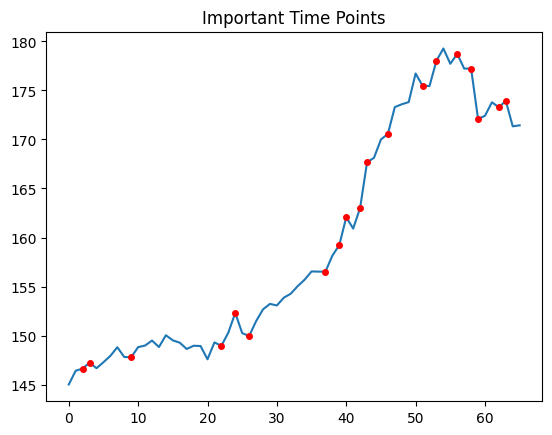

In [27]:
from modelling.grad_explain import integrated_gradients

baseline = torch.zeros_like(x)
ig = integrated_gradients(x, edge_index, baseline, model)
plot_contributions(ig[0])
visualize_sequence_with_highlights(x[0], ig[0])

In [18]:
top_n = 10

# Find the incoming edges to the target node
target_edges = torch.where(edge_index[1] == node_index)[0]

contributing_nodes = []
for target_edge in target_edges:
    contributing_node = edge_index[0, target_edge]
    importance = explanation.edge_mask[target_edge]
    contributing_nodes.append((contributing_node.item(), importance.item()))

# Sort based on weight importance
sorted_contributing_nodes = sorted(contributing_nodes, key=lambda x: x[1], reverse=True)

target_node_name = names[node_index]

print(f"The top {min(top_n, len(sorted_contributing_nodes))} nodes that most strongly contribute to {target_node_name} are:")
for i in range(min(top_n, len(sorted_contributing_nodes))):
    sorte = sorted_contributing_nodes[i][0]
    node_name = names[sorte]
    importance = sorted_contributing_nodes[i][1]
    print(f"{node_name} with an importance score of {importance:.4f}")

The top 3 nodes that most strongly contribute to DLR are:
EQIX with an importance score of 0.8235
DHR with an importance score of 0.8192
DOC with an importance score of 0.8186
